# Analysis of annihilation rates with amax fixed
Tim Tyree<br>
9.13.2022

In [2]:
from lib.my_initialization import *
from lib import *
#from lib.lib_care.measure.level_sets import comp_longest_level_set_and_smooth
%load_ext autoreload
%autoreload 2

import random,scipy
from scipy.interpolate import LinearNDInterpolator
from scipy.interpolate import CloughTocher2DInterpolator
from scipy.optimize import minimize
#load libraries for color bar
import matplotlib as mpl #for colorbar
from matplotlib.cm import ScalarMappable
import matplotlib.colors as colors
import matplotlib.cbook as cbook
from matplotlib import cm
#def plotter_3dpoint_cloud_sample(az,...):
from scipy import stats
#DONE: hook this routine up to dask
#DONT: hook this routine up to dask_cuda
# import scanpy as sc
darkmode=False
if darkmode:
    # For darkmode plots
    from jupyterthemes import jtplot
    jtplot.style(theme='monokai', context='notebook', ticks=True, grid=False)
#     theme=cuxfilter.themes.dark
#     #     theme=cuxfilter.themes.rapids
else:
    sns.set_style('white')
#     theme=cuxfilter.themes.light
import warnings
warnings.simplefilter("ignore", UserWarning)
%load_ext autoreload
%autoreload 2
# import cupy as cp
np.random.seed(42)
# cp.random.seed(42)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
from lib.lib_care.routines.interp_texture_from_scatter_data import interp_txt_from_scatter

In [4]:
#reset matplotlib settings
from mpltools import annotation
import matplotlib as mpl
sns.reset_orig()
mpl.rc_file_defaults()

# define module

# build minimum dataset from best fits cached for either of the full models at either of the length scales

In [5]:

latest_run_num=26
run_num_lst = list(reversed(list(np.arange(14,latest_run_num+1))))
# run_num_lst=[25,17]
# run_num_lst=[25,19]
run_num_lst=[25,18]
# run_num_lst=[25,24]
# run_num_lst = list(np.arange(12,26))
# run_num_lst = list(np.arange(26,14))


In [6]:
remove_no_diffusion=True
# Dinf=0
Dinf=0.01
num_digits_round_amax=3
# run_num=25 #L=5 cm
# run_num=18 #L=10 cm
gmin_fk_lst=[]
gmin_lr_lst=[]
log_dir_fk_lst=[]
log_dir_lr_lst=[]
dict_results_fk_lst=[]
dict_results_lr_lst=[]
# for run_num in [25,18]: #chosen exemplar pair
for run_num in run_num_lst:
    parquet_dir_defects_fk=f'/home/timothytyree/Documents/GitHub/bgmc/python/data/osg_output/run_{run_num}_defects_to_fk.parquet'
    parquet_dir_defects_lr=f'/home/timothytyree/Documents/GitHub/bgmc/python/data/osg_output/run_{run_num}_defects_to_lr.parquet'
    input_folder=f'/home/timothytyree/Documents/GitHub/bgmc/python/data/osg_output/run_{run_num}_all'
    #load data
    df_defects_fk=pd.read_parquet(parquet_dir_defects_fk)
    df_defects_lr=pd.read_parquet(parquet_dir_defects_lr)
    #compute order parameter for each member a=amax-2*D
    #add columns for amax
    df_defects_fk['amax'] = np.around(df_defects_fk['varkappa'] + 2.*df_defects_fk['D'],num_digits_round_amax)
    df_defects_lr['amax'] = np.around(df_defects_lr['varkappa'] + 2.*df_defects_lr['D'],num_digits_round_amax)
    
    if remove_no_diffusion:
        df_defects_fk = df_defects_fk[df_defects_fk['D']>Dinf].copy()
        df_defects_lr = df_defects_lr[df_defects_lr['D']>Dinf].copy()
    
    #identify the lowest error simulation for each amax value
    print(f"\n**************************************")
    print(f"* Fenton-Karma Model (best settings):")
    print(f"**************************************")
    minrmse=9999.
    supamax=1.8
    #supamax=40.
    for amax,g in df_defects_fk.groupby(by='amax'):
        rmse_min = g['rmse'].min()
        count = g['rmse'].count()
        log_likelihood = g['log_likelihood'].max()
        if (rmse_min<=minrmse)&(amax<=supamax):
            minrmse=rmse_min
            gmin_fk=g.copy()
            print_str =f"{amax=:.4f}, {rmse_min=:.4f}, {log_likelihood=:.4f}, {count=}"
    print(print_str)
    gmin_fk.sort_values(by='D',inplace=True)
    

    #find best simulation for the full model at this avalue
#     dg_fk=gmin_fk[gmin_fk['rmse'] == gmin_fk['rmse'].min()].copy()
    dg_fk=gmin_fk[gmin_fk['log_likelihood'] == gmin_fk['log_likelihood'].max()].copy()
    dg_fk['run']=run_num
    dg_fk['model']='Fenton-Karma'
    cluster_index,job_index = dg_fk[['cluster_index','job_index']].values.T
    input_fn = os.path.join(input_folder,f"job.out.{int(cluster_index)}.{int(job_index)}")
    #assert os.path.exists(input_fn)
    if os.path.exists(input_fn):
        input_fn_fk=input_fn
        df_fit_fk,dict_linear_fit_fk = routine_measure_annihilation_defect(input_fn,printing=True)#,**kwargs)
        amax_fk=dg_fk['amax'].median()
        rmse_fk=dg_fk['rmse'].median()
        L = dg_fk['L'].median()
        print(f"\nbest fit for Fenton-Karma: RMSE: {rmse_fk:.4f} Hz/cm^2, amax: {amax_fk:.4f} cm^2/s, L: {L} cm")
        print(f"{input_fn_fk=}")
        #record
        dict_results_fk=dict(
            model_name='Fenton-Karma',
            amax=amax_fk,
            rmse=rmse_fk,
            L=L,
            df_fit=df_fit_fk,
            dg_fit=dg_fk,
            dict_linear_fit=dict_linear_fit_fk,
            filename=input_fn_fk,
            gmin=gmin_fk)
        dict_results_fk_lst.append(dict_results_fk)
        gmin_fk_lst.append(gmin_fk)
        log_dir_fk_lst.append(input_fn)
    
    #identify the lowest error simulation for each amax value
    print(f"\n**************************************")
    print(f"* Luo-Rudy Model (best settings):")
    print(f"**************************************")
    minrmse=9999.
    supamax=10.2
    for amax,g in df_defects_lr.groupby(by='amax'):
        rmse_min = g['rmse'].min()
        count = g['rmse'].count()
        log_likelihood = g['log_likelihood'].max()
        if (rmse_min<=minrmse)&(amax<=supamax):
            minrmse=rmse_min
            gmin_lr=g.copy()
            print_str =f"{amax=:.4f}, {rmse_min=:.4f}, {log_likelihood=:.4f}, {count=}"
    print(print_str)        
    gmin_lr.sort_values(by='D',inplace=True)
    
    #find best simulation for the full model at this avalue
#     dg_lr=gmin_lr[gmin_lr['rmse'] == gmin_lr['rmse'].min()].copy()
    dg_lr=gmin_lr[gmin_lr['log_likelihood'] == gmin_lr['log_likelihood'].max()].copy()
    dg_lr['run']=run_num
    dg_lr['model']='Luo-Rudy'
    cluster_index,job_index = dg_lr[['cluster_index','job_index']].values.T
    input_fn = os.path.join(input_folder,f"job.out.{int(cluster_index)}.{int(job_index)}")
    #assert os.path.exists(input_fn)
    if os.path.exists(input_fn):
        input_fn_lr=input_fn
        df_fit_lr,dict_linear_fit_lr = routine_measure_annihilation_defect(input_fn,printing=True)#,**kwargs)
        amax_lr=dg_fk['amax'].median()
        rmse_lr=dg_lr['rmse'].median()
        L = dg_lr['L'].median()
        print(f"\nbest fit for Luo-Rudy: RMSE: {rmse_lr:.4f} Hz/cm^2, amax: {amax_lr:.4f} cm^2/s, L: {L} cm")
        print(f"{input_fn_lr=}")
        #record
        dict_results_lr=dict(
            model_name='Luo-Rudy',
            amax=amax_lr,
            rmse=rmse_lr,
            L=L,
            df_fit=df_fit_lr,
            dg_fit=dg_lr,
            dict_linear_fit=dict_linear_fit_lr,
            filename=input_fn_lr,
            gmin=gmin_lr)
        dict_results_lr_lst.append(dict_results_lr)
        gmin_lr_lst.append(gmin_lr)
        log_dir_lr_lst.append(input_fn)

    print(f"\nparameter range supported in run #{run_num}:")
    print(f"number of trials: {df_defects_lr.shape[0]}")
    print(df_defects_lr.describe()[['r','kappa','D','varkappa','amax','L','neighbor']].T[['min','max']].T)





**************************************
* Fenton-Karma Model (best settings):
**************************************
amax=1.7810, rmse_min=0.0911, log_likelihood=7.0307, count=4410

best fit for Fenton-Karma: RMSE: 0.1402 Hz/cm^2, amax: 1.7810 cm^2/s, L: 5.0 cm
input_fn_fk='/home/timothytyree/Documents/GitHub/bgmc/python/data/osg_output/run_25_all/job.out.22996017.672'

**************************************
* Luo-Rudy Model (best settings):
**************************************
amax=10.1490, rmse_min=0.1695, log_likelihood=10.1045, count=4410

best fit for Luo-Rudy: RMSE: 0.1942 Hz/cm^2, amax: 1.7810 cm^2/s, L: 5.0 cm
input_fn_lr='/home/timothytyree/Documents/GitHub/bgmc/python/data/osg_output/run_25_all/job.out.22996017.3351'

parameter range supported in run #25:
number of trials: 17640
        r  kappa      D  varkappa    amax    L  neighbor
min  0.01  100.0  0.090     1.553   1.733  5.0       1.0
max  0.49  990.0  0.114     9.969  10.197  5.0       1.0

**************************

In [7]:
# len(dict_results_fk_lst)
# !pwd

# Plot mean annihilation rates

In [8]:
dict_wjr = recall_death_rates_vidmar_rappel()
fk=dict_wjr['fk']
lr=dict_wjr['lr']

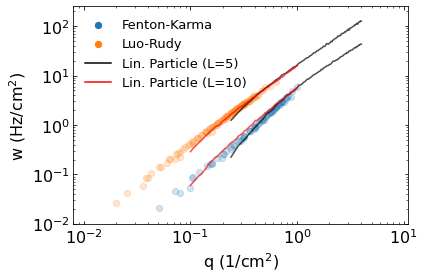

In [9]:
figsize = (6, 4)  #(5,4)
fontsize=16
fig, ax = plt.subplots(figsize=figsize)
ax = plot_death_rates_loglog_full(fk,lr,ax=ax,fontsize=fontsize,x1lim=[0.008, 11], x2lim=[0.01, 250])

# Linear Particle (L=5)
df_fit_fk = dict_results_fk_lst[0]['df_fit']
dg_fit_fk = dict_results_fk_lst[0]['dg_fit']
df_fit_lr = dict_results_lr_lst[0]['df_fit']
dg_fit_lr = dict_results_lr_lst[0]['dg_fit']
df_fit_fk.plot(x='q',y='w',alpha=0.7,ax=ax,color='k',label=f'Lin. Particle (L=5)')#,label='_Best Fit to FK')
df_fit_lr.plot(x='q',y='w',alpha=0.7,ax=ax,color='k',label='_Best Fit to LR')

# Linear Particle (L=10)
df_fit_fk = dict_results_fk_lst[1]['df_fit']
dg_fit_fk = dict_results_fk_lst[1]['dg_fit']
df_fit_lr = dict_results_lr_lst[1]['df_fit']
dg_fit_lr = dict_results_lr_lst[1]['dg_fit']
# df_fit_fk.plot(x='q',y='w',alpha=0.7,ax=ax,color='r',label=f'Linear Particle (L=10)')#,label='_Best Fit to FK')
df_fit_fk.plot(x='q',y='w',alpha=0.7,ax=ax,color='r',label=f'Lin. Particle (L=10)')#,label='_Best Fit to FK')
df_fit_lr.plot(x='q',y='w',alpha=0.7,ax=ax,color='r',label='_Best Fit to LR')

# format_plot
ax.tick_params(top=True, right=True,direction='in',which='both')
format_plot(ax=ax,xlabel=r'q (1/cm$^2$)',ylabel=r'w (Hz/cm$^2$)',fontsize=fontsize,use_loglog=True)
# ax.legend(loc='upper left',fontsize=fontsize-2)
# ax.legend(loc='lower right',fontsize=fontsize-2.,frameon=False,ncol=2)
# leg = ax.legend(loc=(1.04,0.2),fontsize=fontsize-2.,frameon=False)
leg = ax.legend(loc='upper left',fontsize=fontsize-3.,frameon=False,ncol=1)
for lh in leg.legendHandles: 
    lh.set_alpha(1)
# ax.get_legend().remove()

#add annotation
# xytext=(0.09, 10)
# xytext=(0.01, 90)
# ax.annotate(r"best fit ($a>0$)", xy=xy, xytext=xytext,fontsize=fontsize)
# .tick_params(labelbottom=False, labeltop=True, labelleft=False, labelright=False,
#                      bottom=False, top=True, left=False, right=False)

xytext=(0.01, 40)
xy=(0.3, 11)
# ax.annotate(r"$a_{max}$ = const.", xy=xy, xytext=(0.01, 40),fontsize=fontsize-2)
# ax.annotate(r"$a_{max}$ fixed to observed", xy=xy, xytext=(0.01, 40),fontsize=fontsize-2)
# ax.annotate(r"$a_{max}$ fixed to observation"+f"\nfrom MSR of full", xy=xy, xytext=(0.01, 40),fontsize=fontsize-2)
# #add marker showing the slope of ~2
# annotation.slope_marker(origin=(.75, 2.0),
#                         slope=2,
#                         text_kwargs={'color': 'black','fontsize':16, 'alpha':0.7},
#                         poly_kwargs={'facecolor': (0.5, 0.5, 0.5), 'alpha':0.5},
#                         ax=ax)
plt.show()

In [10]:
dh_lst=[]
col_lst=['model','amax','L','varkappa','D','r','kappa',
           'rmse','log_likelihood','neighbor',
           'q_lo', 'q_hi','CollTime_lo', 'CollTime_hi','N_lo', 'N_hi',
          'run','cluster_index', 'job_index']

for dict_results_fk in dict_results_fk_lst:
    dg_fit_fk = dict_results_fk['dg_fit']
    dh_lst.append(dg_fit_fk[col_lst])
    #dg_fit_fk = dict_results_fk['dg_fit']
    #dh_lst.append(dg_fit_fk[col_lst])

for dict_results_lr in dict_results_lr_lst:
    dg_fit_lr = dict_results_lr['dg_fit']
    dh_lst.append(dg_fit_lr[col_lst])
    #dg_fit_lr = dict_results_lr['dg_fit']
    #dh_lst.append(dg_fit_lr[col_lst])
df_annihil_fits = pd.concat(dh_lst)
# df_annihil_fits.reset_index(inplace=True)
df_annihil_fits.sort_values(by=['model','rmse'],inplace=True)
df_annihil_fits

,model,amax,L,varkappa,D,r,kappa,rmse,log_likelihood,neighbor,q_lo,q_hi,CollTime_lo,CollTime_hi,N_lo,N_hi,run,cluster_index,job_index
1979,Fenton-Karma,1.781,5.0,1.55300,0.11400,0.02000,880.000,0.140241,7.030700,1.0,0.24,4.0,0.000927,0.178568,6.0,100.0,25,22996017,672
13680,Fenton-Karma,1.793,10.0,1.64822,0.07252,0.10393,263.738,0.175862,78.872984,0.0,0.10,1.0,0.001754,0.166719,10.0,100.0,18,16106771,1096
10855,Luo-Rudy,10.148,10.0,9.22091,0.46368,0.15693,290.921,0.128481,74.140323,0.0,0.10,1.0,0.000618,0.034681,10.0,100.0,18,16106771,5486
9491,Luo-Rudy,10.149,5.0,9.96900,0.09000,0.10000,370.000,0.194177,10.104532,1.0,0.24,4.0,0.000313,0.032113,6.0,100.0,25,22996017,3351


In [11]:
# annihil_fits_dir = f'/home/timothytyree/Documents/GitHub/bgmc/python/data/annihil_fits.{run_num_lst[0]}.{run_num_lst[1]}.csv'
annihil_fits_dir = f'/home/timothytyree/Documents/GitHub/bgmc/python/data/annihil_fits.'
for run_num in run_num_lst:
    annihil_fits_dir += f"{run_num}."
annihil_fits_dir+='csv'
print(f"{annihil_fits_dir=}")
#save as .csv and send to WJ right now!
# annihil_fits_dir = '/home/timothytyree/Documents/GitHub/bgmc/python/data/annihil_fits.csv'
df_annihil_fits.to_csv(annihil_fits_dir,index=False)
print(df_annihil_fits)

annihil_fits_dir='/home/timothytyree/Documents/GitHub/bgmc/python/data/annihil_fits.25.18.csv'
              model    amax     L  varkappa        D        r    kappa  \
1979   Fenton-Karma   1.781   5.0   1.55300  0.11400  0.02000  880.000   
13680  Fenton-Karma   1.793  10.0   1.64822  0.07252  0.10393  263.738   
10855      Luo-Rudy  10.148  10.0   9.22091  0.46368  0.15693  290.921   
9491       Luo-Rudy  10.149   5.0   9.96900  0.09000  0.10000  370.000   

           rmse  log_likelihood  neighbor  q_lo  q_hi  CollTime_lo  \
1979   0.140241        7.030700       1.0  0.24   4.0     0.000927   
13680  0.175862       78.872984       0.0  0.10   1.0     0.001754   
10855  0.128481       74.140323       0.0  0.10   1.0     0.000618   
9491   0.194177       10.104532       1.0  0.24   4.0     0.000313   

       CollTime_hi  N_lo   N_hi  run  cluster_index  job_index  
1979      0.178568   6.0  100.0   25       22996017        672  
13680     0.166719  10.0  100.0   18       16106771  

In [12]:
print(f"Table of maximum likelihood fits of linear particle model to full models.")
print(df_annihil_fits[['model','amax','L','rmse']])

Table of maximum likelihood fits of linear particle model to full models.
              model    amax     L      rmse
1979   Fenton-Karma   1.781   5.0  0.140241
13680  Fenton-Karma   1.793  10.0  0.175862
10855      Luo-Rudy  10.148  10.0  0.128481
9491       Luo-Rudy  10.149   5.0  0.194177


# TODO: make table of powerlaw fits

- TODO: make powerlaw fits for particle model
- TODO: plot ^those and verify they look reasonable
- TODO: recall wjr fits
- TODO: stack these values into a pandas data frame
- TODO: print as table, save as powerlaw_fits.csv

In [13]:
wjr=recall_powerlaw_fits_to_full_models()

In [14]:
# Linear Particle (L=5)
df_fit_fk = dict_results_fk_lst[0]['df_fit'].sort_values(by='q')
# dg_fit_fk = dict_results_fk_lst[0]['dg_fit']
df_fit_lr = dict_results_lr_lst[0]['df_fit'].sort_values(by='q')
# dg_fit_lr = dict_results_lr_lst[0]['dg_fit']

# Linear Particle (L=10)
df_fit_fk = dict_results_fk_lst[1]['df_fit'].sort_values(by='q')
# dg_fit_fk = dict_results_fk_lst[1]['dg_fit']
df_fit_lr = dict_results_lr_lst[1]['df_fit'].sort_values(by='q')
# dg_fit_lr = dict_results_lr_lst[1]['dg_fit']
# dg_fit_fk.columns

In [15]:
df=df_fit_fk
m=wjr['fk_pbc']['m']
M=wjr['fk_pbc']['M']
qmin=0.1
qmax=1.0
q_values = df['q'].values
w_values = df['w'].values 
boo=(q_values>=qmin)&(q_values<qmax)
x=q_values[boo]
y=w_values[boo]
yhat=M*x**m

In [19]:
dict_fit = print_fit_power_law(x,y)
# print_dict(dict_fit)

m = 1.894455 +/- 0.022203
M = 5.678515 +/- 0.230815 Hz/cm^2; B=2.501080 +/- 0.025561
RMSE=0.1493 Hz/cm^2; R^2=0.9969; N=90


In [78]:
rv

In [61]:
wjr['fk_pbc']

{'m': 1.8772341309722325,
 'Delta_m': 0.02498750277237229,
 'M': 5.572315674840435,
 'Delta_M': 0.3053120355191732,
 'b': 1.665608066257863,
 'Delta_b': 0.029341409948945123}

In [95]:
#TODO: restart run 25 as run 27 but with neighbors=0

In [56]:
wjr['fk_pbc']

NameError: name 'wjr' is not defined

In [ ]:
print(f"Table of powerlaw fits of maximum likelihood fits of pair annihilation rates.")
print(df_annihil_fits[['model','amax','L','rmse']])

# DONE: make table of particle parameters

In [21]:
def format_measurement_string(key,val,Delta_val,num_digits=6):
    if num_digits==0:
        return f"{key} = {val:.0f} +/- {Delta_val:.0f}"
    if num_digits==2:
        return f"{key} = {val:.2f} +/- {Delta_val:.2f}"
    if num_digits==4:
        return f"{key} = {val:.4f} +/- {Delta_val:.4f}"
    if num_digits==6:
        return f"{key} = {val:.6f} +/- {Delta_val:.6f}"
    if num_digits==8:
        return f"{key} = {val:.6f} +/- {Delta_val:.6f}"
    raise f"Argument Error: {num_digits=} not yet implemented!\nconsider num_digits as an even number less than 10..."

In [20]:
#TODO: dev foo that maps a .csv to a latex table

#HINT: search stackoverflow
#TODO: make mle parameter table into latex table
#HINT: query the dataframe and then search stackoverflow
# TODO: wrap in modules of foo

# TODO: plot the fits for increasing/decreasing D.
Q: does it make sense to plot other variables versus D?

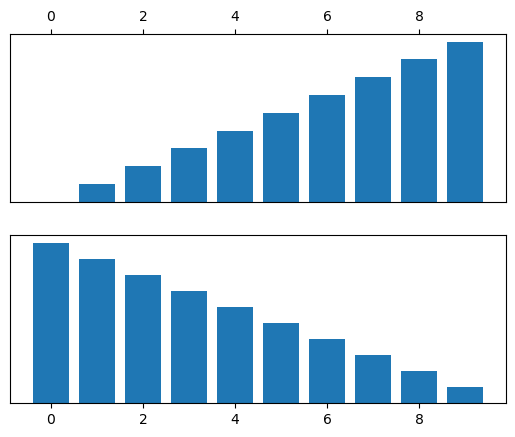

In [31]:
f, axarr = plt.subplots(2)

axarr[0].bar(range(10), range(10))
axarr[0].tick_params(labelbottom=False, labeltop=True, labelleft=False, labelright=False,
                     bottom=False, top=True, left=False, right=False)

axarr[1].bar(range(10), range(10, 0, -1))
axarr[1].tick_params(labelbottom=True, labeltop=False, labelleft=False, labelright=False,
                     bottom=True, top=False, left=False, right=False)